In [27]:
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tqdm import tqdm

## Design Idea

In [2]:
span = 2540
offset = -25
slice_heigth = 161

(2857, 3058, 3)


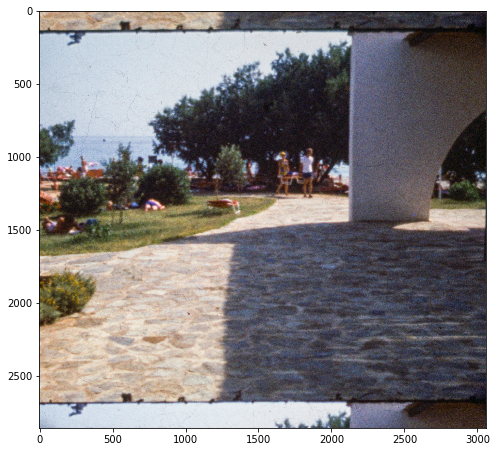

In [3]:
imgpath = "/Users/jankaiser/Desktop/stab_test/frame-00702.jpg"
img = cv2.imread(imgpath, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(img.shape)

plt.figure(figsize=(8,8))
plt.imshow(img, interpolation="none")
plt.show()

In [4]:
def extract_sample(frame, span=2540, offset=-25, slice_heigth=161):
    bw = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    normed = bw / 255
    
    middle = normed.shape[0] / 2
    upper = middle + offset - span / 2
    lower = middle + offset + span / 2

    upper_slice = normed[int(upper-slice_heigth/2):int(upper+slice_heigth/2),:]
    lower_slice = normed[int(lower-slice_heigth/2):int(lower+slice_heigth/2),:]

    upper_squashed = cv2.resize(upper_slice, (161,161))
    lower_squashed = cv2.resize(lower_slice, (161,161))

    sample = np.stack([upper_squashed,lower_squashed])
    sample = np.moveaxis(sample, 0, -1)
    return sample

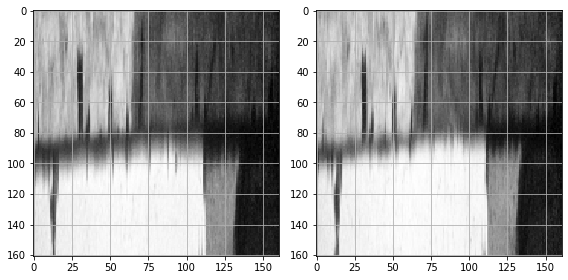

In [5]:
sample = extract_sample(img, span=span, offset=offset, slice_heigth=slice_heigth)

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(sample[:,:,0], cmap="gray", interpolation="none")
plt.grid()
plt.subplot(122)
plt.imshow(sample[:,:,1], cmap="gray", interpolation="none")
plt.grid()
plt.tight_layout()
plt.show()

In [61]:
directory = "/Users/jankaiser/Desktop/stab_test/original"
imgpaths = glob.glob(os.path.join(directory, "frame-*.jpg"))
print(len(imgpaths))
print(imgpaths[:5])

41
['/Users/jankaiser/Desktop/stab_test/original/frame-00705.jpg', '/Users/jankaiser/Desktop/stab_test/original/frame-00711.jpg', '/Users/jankaiser/Desktop/stab_test/original/frame-00710.jpg', '/Users/jankaiser/Desktop/stab_test/original/frame-00704.jpg', '/Users/jankaiser/Desktop/stab_test/original/frame-00712.jpg']


In [62]:
imgs = [cv2.imread(imgpath, cv2.IMREAD_COLOR) for imgpath in imgpaths]
inputs = [extract_sample(img, span=span, offset=offset, slice_heigth=slice_heigth) for img in imgs]

In [80]:
for inpt, srcpath in zip(inputs, tqdm(imgpaths)):
    glued = np.zeros((161,161*2), dtype="uint8")
    glued[:,:161] = inpt[:,:,0] * 255
    glued[:,161:] = inpt[:,:,1] * 255

    dstpath = srcpath[:-24] + "inputs/" + srcpath[-15:]
    cv2.imwrite(dstpath, glued)

 98%|█████████▊| 40/41 [00:00<00:00, 296.26it/s]


## Create Training Data

(1335, 2000, 3)


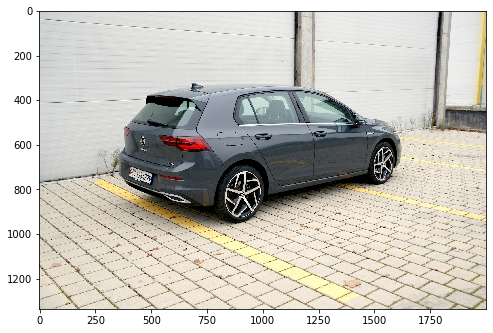

In [6]:
train_img = cv2.imread("/Users/jankaiser/Downloads/@Test-VW-Golf-8-4.jpeg", cv2.IMREAD_COLOR)
# train_img = cv2.imread("/Users/jankaiser/Downloads/gettyimages-632497192-2000.jpg", cv2.IMREAD_COLOR)
train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)

print(train_img.shape)

plt.figure(figsize=(8,8))
plt.imshow(train_img, interpolation="none")
plt.show()

In [7]:
def resize_to_fill(img, new_size):
    old_ar = img.shape[1] / img.shape[0]
    new_ar = new_size[1] / new_size[0]

    if old_ar > new_ar:
        crop_width = int(img.shape[0] * new_ar)
        cutoff = int((img.shape[1] - crop_width) / 2)
        cropped = img[:,cutoff:-cutoff]
    else:
        crop_height = int(img.shape[1] / new_ar)
        cutoff = int((img.shape[0] - crop_height) / 2)
        cropped = img[cutoff:-cutoff,:]
        
    resized = cv2.resize(cropped, (new_size[1],new_size[0]))
    return resized

(2540, 3058, 3)


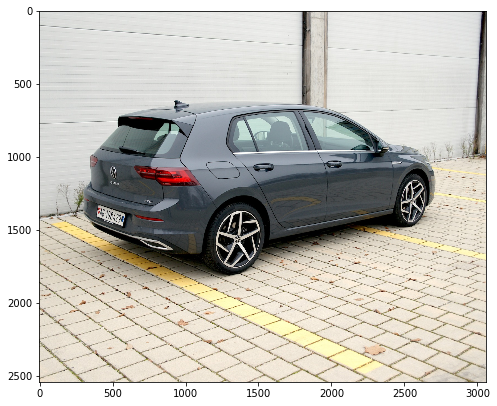

In [8]:
resized = resize_to_fill(train_img, (span,img.shape[1]))
print(resized.shape)

plt.figure(figsize=(8,8))
plt.imshow(resized, interpolation="none")
plt.show()

In [9]:
def draw_frame(img, sample_shape, offset, wabble, du, dl):
    ypos = int((sample_shape[0] - img.shape[0]) / 2 + offset + wabble)

    sample = np.zeros(sample_shape, dtype="uint8")
    sample[ypos:ypos+img.shape[0]] = img

    uypos = ypos - img.shape[0] - int(du)
    uheight = uypos + img.shape[0]
    sample[0:uheight] = img[-uheight:]

    lypos = ypos + img.shape[0] + int(dl)
    lheight = sample.shape[0] - lypos
    sample[-lheight:] = img[:lheight]

    return sample

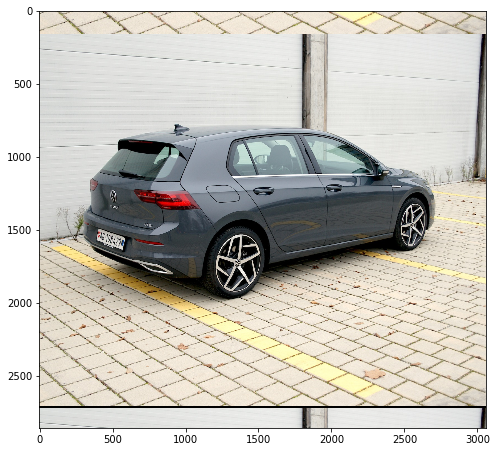

In [10]:
frame = draw_frame(
    resized,
    img.shape,
    offset,
    wabble=np.random.uniform(-40,40),
    du=np.random.uniform(0,20),
    dl=np.random.uniform(0,20)
)

plt.figure(figsize=(8,8))
plt.imshow(frame, interpolation="none")
plt.show()

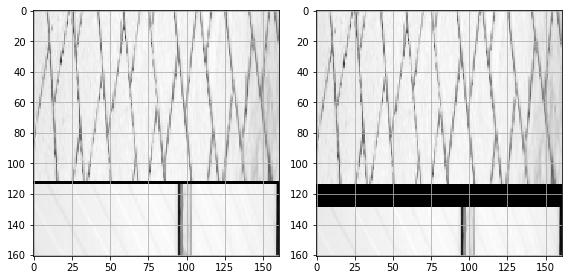

In [11]:
sample = extract_sample(frame, span=span, offset=offset, slice_heigth=slice_heigth)

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(sample[:,:,0], cmap="gray", interpolation="none")
plt.grid()
plt.subplot(122)
plt.imshow(sample[:,:,1], cmap="gray", interpolation="none")
plt.grid()
plt.tight_layout()
plt.show()

In [12]:
def create_train_sample(imgpath, span, offset, slice_heigth, max_wabble, max_d):
    wabble = np.random.uniform(-max_wabble,max_wabble)

    bgr = cv2.imread(imgpath, cv2.IMREAD_COLOR)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    resized = resize_to_fill(rgb, (span,img.shape[1]))
    frame = draw_frame(
        resized,
        img.shape,
        offset,
        wabble=wabble,
        du=np.random.uniform(0,max_d),
        dl=np.random.uniform(0,max_d)
    )

    sample = extract_sample(frame, span=span, offset=offset, slice_heigth=slice_heigth)

    return sample, wabble

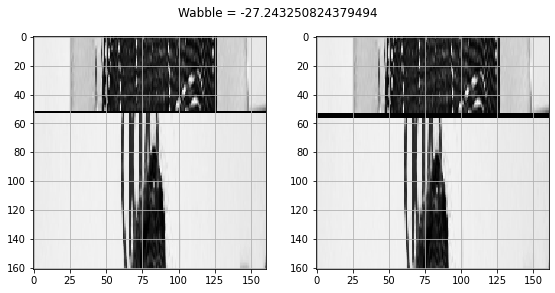

In [13]:
sample = create_train_sample(
    "/Users/jankaiser/Downloads/gettyimages-632497192-2000.jpg",
    span=span,
    offset=offset,
    slice_heigth=slice_heigth,
    max_wabble=40,
    max_d=20
)

plt.figure(figsize=(8,4))
plt.suptitle(f"Wabble = {sample[1]}")
plt.subplot(121)
plt.imshow(sample[0][:,:,0], cmap="gray", interpolation="none")
plt.grid()
plt.subplot(122)
plt.imshow(sample[0][:,:,1], cmap="gray", interpolation="none")
plt.grid()
plt.tight_layout()
plt.show()

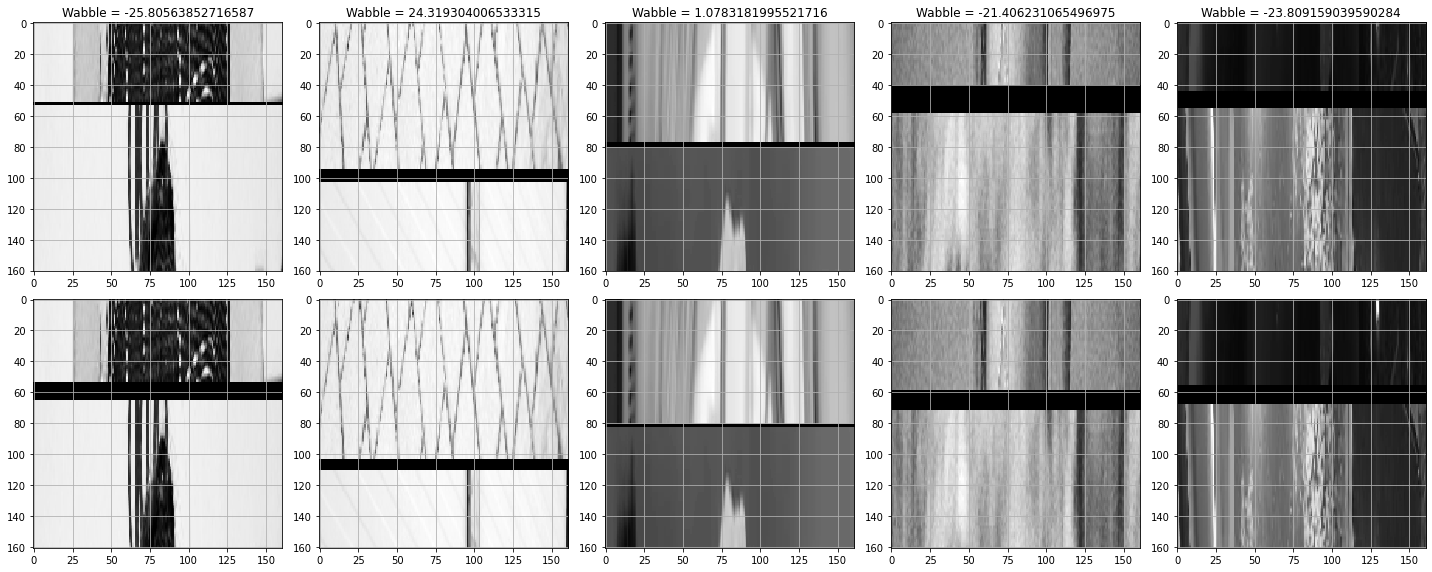

In [14]:
imgpaths = [
    "/Users/jankaiser/Downloads/gettyimages-632497192-2000.jpg",
    "/Users/jankaiser/Downloads/@Test-VW-Golf-8-4.jpeg",
    "/Users/jankaiser/Downloads/Screenshot 2021-10-29 at 15.38.59.png",
    "/Users/jankaiser/Downloads/19321040610_920395f4aa_o.jpg",
    "/Users/jankaiser/Downloads/maxresdefault.jpg"
]
samples = [create_train_sample(
    imgpath,
    span=span,
    offset=offset,
    slice_heigth=slice_heigth,
    max_wabble=40,
    max_d=20
) for imgpath in imgpaths]

plt.figure(figsize=(20,8))
for i, sample in enumerate(samples):
    plt.subplot(2, 5, i+1)
    plt.title(f"Wabble = {sample[1]}")
    plt.imshow(sample[0][:,:,0], cmap="gray", interpolation="none")
    plt.grid()
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(sample[0][:,:,1], cmap="gray", interpolation="none")
    plt.grid()
plt.tight_layout()
plt.show()

## Preprocess Dataset

In [15]:
directory = "/Users/jankaiser/Downloads/Dataset4K"
imgpaths = glob.glob(os.path.join(directory, "4k-3840-x-2160-wallpapers-themefoxx (*).jpg"))
print(len(imgpaths))
print(imgpaths[:5])

2056
['/Users/jankaiser/Downloads/Dataset4K/4k-3840-x-2160-wallpapers-themefoxx (301).jpg', '/Users/jankaiser/Downloads/Dataset4K/4k-3840-x-2160-wallpapers-themefoxx (2020).jpg', '/Users/jankaiser/Downloads/Dataset4K/4k-3840-x-2160-wallpapers-themefoxx (751).jpg', '/Users/jankaiser/Downloads/Dataset4K/4k-3840-x-2160-wallpapers-themefoxx (1749).jpg', '/Users/jankaiser/Downloads/Dataset4K/4k-3840-x-2160-wallpapers-themefoxx (1319).jpg']


In [16]:
samples = [create_train_sample(
    imgpath,
    span=span,
    offset=offset,
    slice_heigth=slice_heigth,
    max_wabble=40,
    max_d=20
) for imgpath in tqdm(imgpaths)]

100%|██████████| 2056/2056 [07:28<00:00,  4.58it/s]


In [19]:
X = np.array([sample[0] for sample in samples]).astype("float32")
y = np.array([sample[1] for sample in samples]).astype("float32")
X.shape

(2056, 161, 161, 2)

In [23]:
with open("X_Dataset4k.npy", "wb") as f:
    np.save(f, X)
with open("y_Dataset4k.npy", "wb") as f:
    np.save(f, y)

## Train

In [24]:
with open("X_Dataset4k.npy", "rb") as f:
    X = np.load(f)
with open("y_Dataset4k.npy", "rb") as f:
    y = np.load(f)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [30]:
model = keras.Sequential([
    Conv2D(16, (5,25), strides=(1,7), activation="relu", input_shape=(161,161,2)),
    Conv2D(8, (3,15), strides=(1,1), activation="relu"),
    Flatten(),
    Dense(32, activation="relu"),
    Dense(1)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 157, 20, 16)       4016      
                                                                 
 conv2d_3 (Conv2D)           (None, 155, 6, 8)         5768      
                                                                 
 flatten_1 (Flatten)         (None, 7440)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                238112    
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 247,929
Trainable params: 247,929
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

history = model.fit(X_train, y_train, epochs=50, shuffle=True, validation_data=(X_test,y_test))

Epoch 1/50
44/44 [==============================] - 6s 132ms/step - loss: 12.5160 - mae: 2.3551 - val_loss: 13.9400 - val_mae: 2.0355
Epoch 2/50
44/44 [==============================] - 5s 104ms/step - loss: 6.3590 - mae: 1.5911 - val_loss: 16.1317 - val_mae: 2.6301
Epoch 3/50
44/44 [==============================] - 5s 124ms/step - loss: 6.1888 - mae: 1.6241 - val_loss: 11.4468 - val_mae: 1.7086
Epoch 4/50
44/44 [==============================] - 6s 133ms/step - loss: 4.3537 - mae: 1.3627 - val_loss: 10.8807 - val_mae: 1.6814
Epoch 5/50
44/44 [==============================] - 6s 138ms/step - loss: 4.4481 - mae: 1.4746 - val_loss: 11.3098 - val_mae: 1.6186
Epoch 6/50
44/44 [==============================] - 6s 137ms/step - loss: 3.5433 - mae: 1.2797 - val_loss: 10.1192 - val_mae: 1.5743
Epoch 7/50
44/44 [==============================] - 6s 138ms/step - loss: 2.6560 - mae: 1.1386 - val_loss: 11.0702 - val_mae: 1.4792
Epoch 8/50
44/44 [==============================] - 6s 143ms/step - 

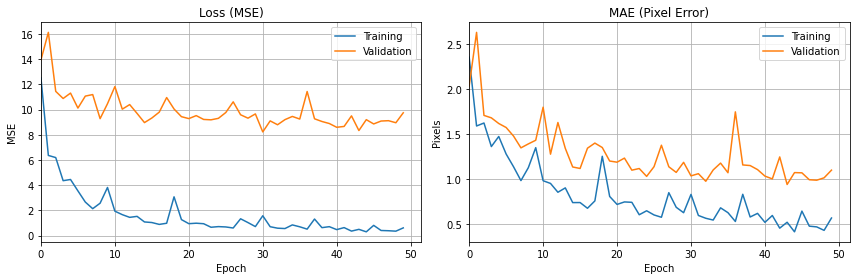

In [39]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title("Loss (MSE)")
plt.plot(history.history["loss"], label="Training")
plt.plot(history.history["val_loss"], label="Validation")
plt.xlim(0, None)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid()
plt.legend()
plt.subplot(122)
plt.title("MAE (Pixel Error)")
plt.plot(history.history["mae"], label="Training")
plt.plot(history.history["val_mae"], label="Validation")
plt.xlim(0, None)
plt.xlabel("Epoch")
plt.ylabel("Pixels")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
model.save("model_Dataset4k_test01")

2021-11-14 21:27:59.609615: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_Dataset4k_test01/assets


## Generate Stabilised Video

In [41]:
model = keras.models.load_model("model_Dataset4k_test01")

In [42]:
directory = "/Users/jankaiser/Desktop/stab_test"
imgpaths = glob.glob(os.path.join(directory, "frame-*.jpg"))
print(len(imgpaths))
print(imgpaths[:5])

41
['/Users/jankaiser/Desktop/stab_test/frame-00705.jpg', '/Users/jankaiser/Desktop/stab_test/frame-00711.jpg', '/Users/jankaiser/Desktop/stab_test/frame-00710.jpg', '/Users/jankaiser/Desktop/stab_test/frame-00704.jpg', '/Users/jankaiser/Desktop/stab_test/frame-00712.jpg']


In [43]:
imgs = [cv2.imread(imgpath, cv2.IMREAD_COLOR) for imgpath in imgpaths]
inputs = [extract_sample(img, span=span, offset=offset, slice_heigth=slice_heigth) for img in imgs]

In [44]:
X = np.array([inpt for inpt in inputs]).astype("float32")
X.shape

(41, 161, 161, 2)

In [46]:
y = model.predict(X)
y.shape

(41, 1)

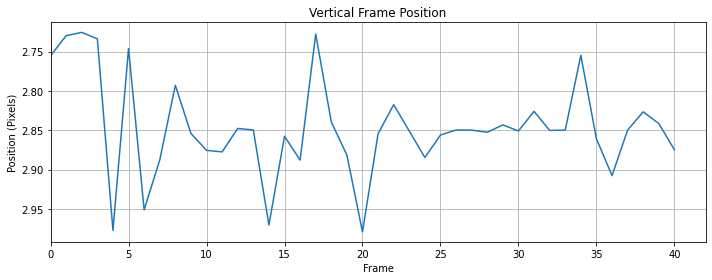

In [54]:
plt.figure(figsize=(10,4))
plt.title("Vertical Frame Position")
plt.plot(y)
plt.xlim(0, None)
plt.xlabel("Frame")
plt.ylabel("Position (Pixels)")
plt.gca().invert_yaxis()
plt.grid()
plt.tight_layout()
plt.show()

In [56]:
for y_shift, img, srcpath in tqdm(zip(y, imgs, imgpaths)):
    y_shift = y_shift[0]
    M = np.float32([
        [1, 0,        0],
        [0, 1, -y_shift]
    ])
    shifted = cv2.warpAffine(img, M, (img.shape[1],img.shape[0]))

    dstpath = srcpath[:-15] + "cnn_shifted/" + srcpath[-15:]
    cv2.imwrite(dstpath, shifted)

41it [00:10,  3.88it/s]
